# **Data Analysis (Solving Business Problem):**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# creating dtabase connection
conn = sqlite3.connect('data/Inventory.db')

# fetching vendor summary data
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)

# filtering data by removing inconsistencies
df = pd.read_sql_query("""SELECT *
                       FROM vendor_sales_summary
                       WHERE GrossProfit > 0
                       AND ProfitMargin > 0
                       AND Totalsalesquantity > 0""", conn)
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,15.95,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
8560,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,65.66,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
8561,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.98,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
8562,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,143.28,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


#### **1. Identify Brands that needs Promotional or Pricing Adjustments which exhibits lower sales performance but higher profit margins**

In [22]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [23]:
print(low_sales_threshold)

560.299


In [24]:
print(high_margin_threshold)

64.97017552750113


In [25]:
# Filter Brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values("TotalSalesDollars"))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [ ]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000] # For Better Visualization 

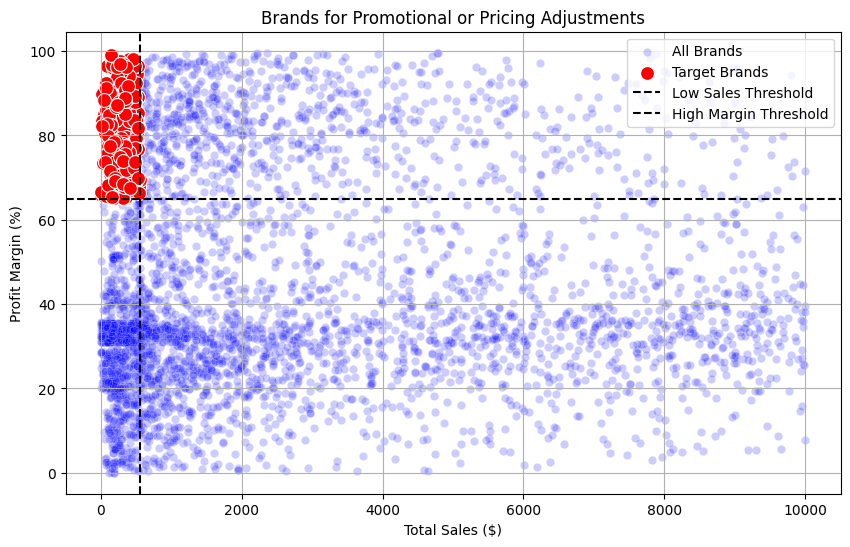

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color='blue', alpha=0.2, label='All Brands')
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color='red', s=100, label='Target Brands')

plt.axvline(x=low_sales_threshold, color='black', linestyle='--', label='Low Sales Threshold')
plt.axhline(y=high_margin_threshold, color='black', linestyle='--', label='High Margin Threshold')

plt.xlabel('Total Sales ($)')
plt.ylabel('Profit Margin (%)')
plt.title('Brands for Promotional or Pricing Adjustments')
plt.legend()
plt.grid(True)
plt.show()

#### **2. Which vendors and brands demonstrate the highest sales performance?**

In [28]:
# Top Vendors & Brands By Sales Perfomance
top_vendors = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)

In [29]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"${value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value/1_000:.2f}K"
    else:
        return str(value)

In [30]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: TotalSalesDollars, dtype: float64

In [31]:
top_brands.apply(format_dollars)

Description
Jack Daniels No 7 Black    $7.96M
Tito's Handmade Vodka      $7.40M
Grey Goose Vodka           $7.21M
Capt Morgan Spiced Rum     $6.36M
Absolut 80 Proof           $6.24M
Jameson Irish Whiskey      $5.72M
Ketel One Vodka            $5.07M
Baileys Irish Cream        $4.15M
Kahlua                     $3.60M
Tanqueray                  $3.46M
Name: TotalSalesDollars, dtype: object

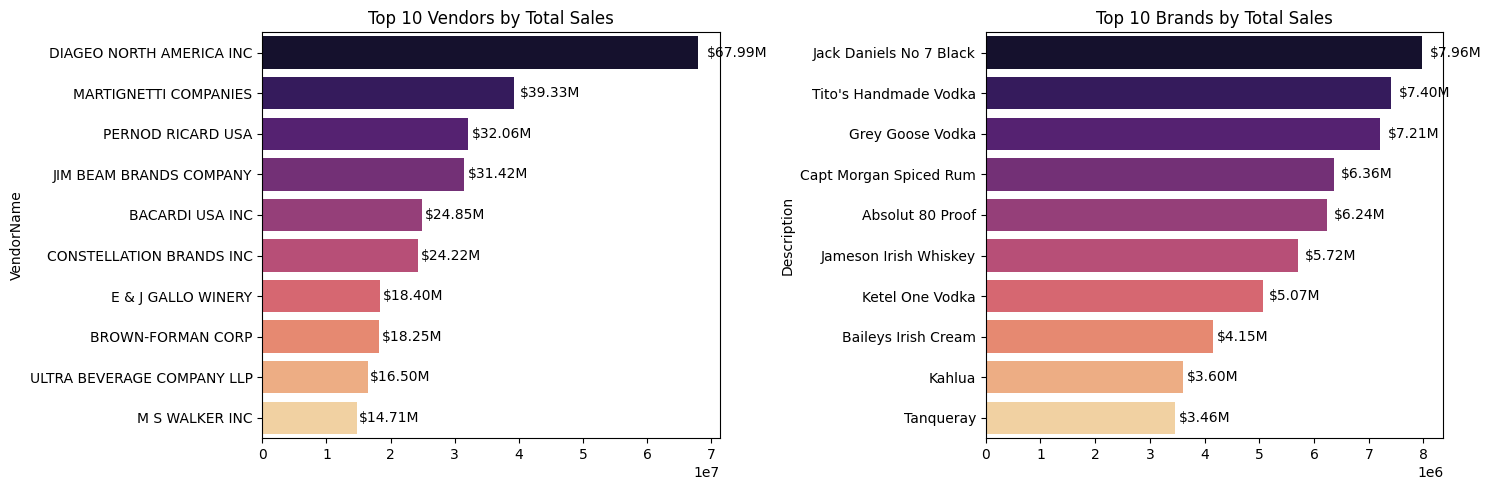

In [32]:
plt.figure(figsize=(15,5))

# Plot for top vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='magma')
plt.title('Top 10 Vendors by Total Sales')

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()*0.02),
             bar.get_y() + bar.get_height()/2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

# Plot for top brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=top_brands.values, y=top_brands.index.astype(str), palette='magma')
plt.title('Top 10 Brands by Total Sales')

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width()*0.02),
             bar.get_y() + bar.get_height()/2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### **3. Which vendors contribute the most to total purchase dollars?**

In [40]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum', 
    'GrossProfit': 'sum', 
    'TotalSalesDollars': 'sum'}).reset_index()

vendor_performance['PurchaseContribution(%)'] = (vendor_performance['TotalPurchaseDollars'] / vendor_performance['TotalPurchaseDollars'].sum()) * 100

vendor_performance = round(vendor_performance.sort_values(by='PurchaseContribution(%)', ascending=False),2)

In [41]:
# Displaying Top 10 Vendors:

top_vendors= vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18


In [42]:
top_vendors['Cumulative_Contribution(%)'] = top_vendors['PurchaseContribution(%)'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%),Cumulative_Contribution(%)
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30,24.60
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64,40.00
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97,50.64
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31,54.95
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63,62.51
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18,65.69


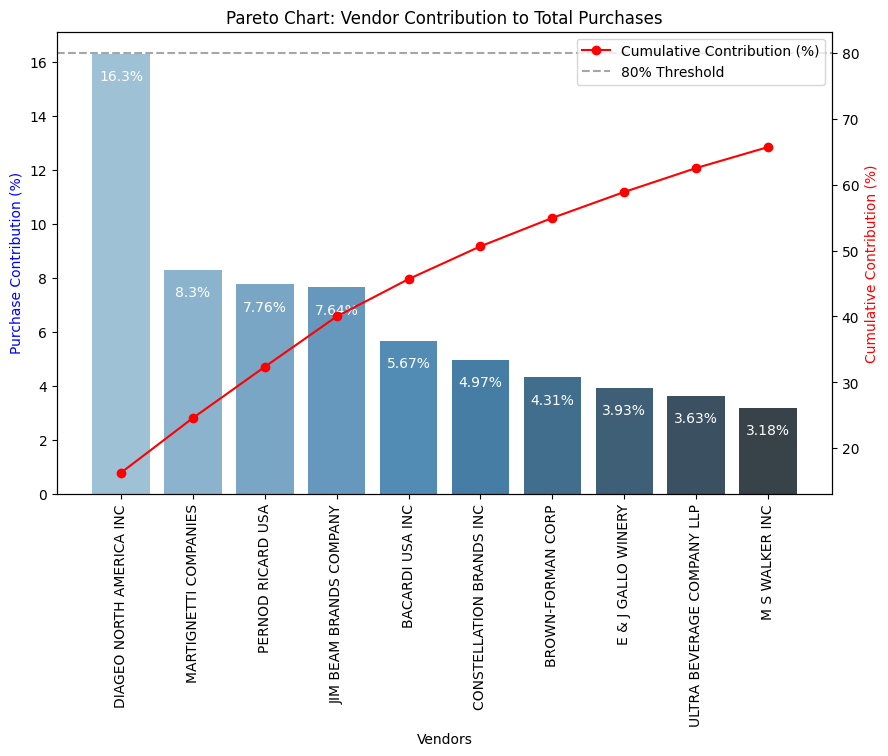

In [48]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for Purchase Contribution
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution(%)'], palette='Blues_d', ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution(%)']):
    ax1.text(i, value - 1, str(value) + "%", ha='center', fontsize=10, color='white')

# line plot for Cumulative Contribution
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution(%)'], color='red', marker='o', linestyle='-', label='Cumulative Contribution (%)')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution (%)', color='blue')
ax2.set_ylabel('Cumulative Contribution (%)', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(80, color='grey', linestyle='--', label = '80% Threshold', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

#### **4. How much of total procurement is dependent on the top vendors?**

In [49]:
print(f"Total Purchase Contribution by Top 10 Vendors: {top_vendors['PurchaseContribution(%)'].sum():.2f}%")

Total Purchase Contribution by Top 10 Vendors: 65.69%


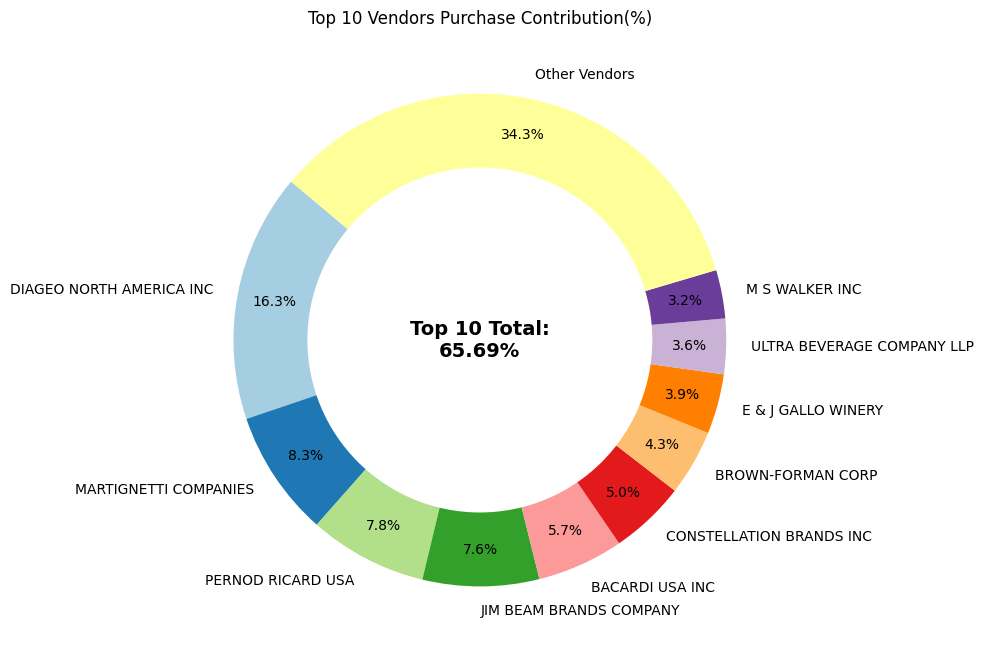

In [52]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution(%)'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%', 
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw circle for donut shape
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution Annotation in the center
plt.text(0, 0, f'Top 10 Total:\n{total_contribution:.2f}%', fontsize=14, fontweight='bold', ha='center', va='center')

plt.title('Top 10 Vendors Purchase Contribution(%)')
plt.show()

#### **5. Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?**

In [53]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [54]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=['Small', 'Medium', 'Large'])

In [56]:
df.groupby('OrderSize')['UnitPurchasePrice'].mean().reset_index()

,OrderSize,UnitPurchasePrice
0,Small,39.068186
1,Medium,15.486414
2,Large,10.777625


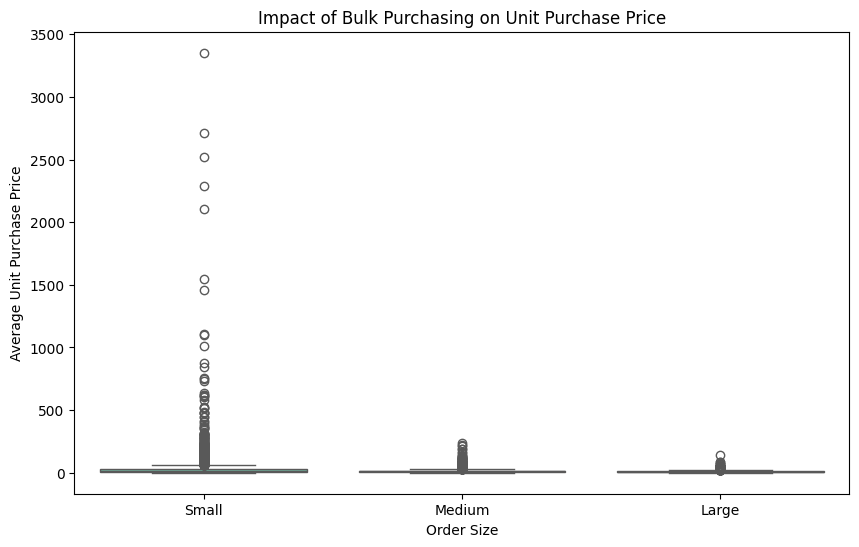

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='OrderSize', y='UnitPurchasePrice', data=df, palette='Set2')
plt.title('Impact of Bulk Purchasing on Unit Purchase Price')
plt.xlabel('Order Size')
plt.ylabel('Average Unit Purchase Price')
plt.show()

## **Insights:**

- Vendors buying bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently

- The price difference between Small and Large orders is substantial (~72% reductiom in unit cost)

- This suggests that bulk pricing strategies successfully encourage vendors to purchase in large volumes, leading to higher overall sales despite lower per-unit revenue

#### **6. Which vendors have low inventory turnover, indicating excess stock and slow-moving products?**

In [58]:
df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values(by='StockTurnover', ascending=True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


#### **7. How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?**

In [59]:
df['UnsoldInventoryValue'] = (df['TotalPurchaseQuantity'] - df['TotalSalesQuantity']) * df['PurchasePrice']
print('Total Unsold Capital:', format_dollars(df['UnsoldInventoryValue'].sum()))

Total Unsold Capital: $2.71M


In [60]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby('VendorName')['UnsoldInventoryValue'].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by='UnsoldInventoryValue', ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,$722.21K
46,JIM BEAM BRANDS COMPANY,$554.67K
68,PERNOD RICARD USA,$470.63K
116,WILLIAM GRANT & SONS INC,$401.96K
30,E & J GALLO WINERY,$228.28K
79,SAZERAC CO INC,$198.44K
11,BROWN-FORMAN CORP,$177.73K
20,CONSTELLATION BRANDS INC,$133.62K
61,MOET HENNESSY USA INC,$126.48K
77,REMY COINTREAU USA INC,$118.60K


####  **8. What is the 95% confidence intervals for profit margins of Top-performing and low-performing vendors**

In [64]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

top_vendors = df[df['TotalSalesDollars'] >= top_threshold]['ProfitMargin'].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]['ProfitMargin'].dropna()

In [65]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))      # standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df= len(data)-1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors Profit Margin: Mean=31.18%, 95% CI=(30.74%, 31.61%)
Low Vendors Profit Margin: Mean=41.57%, 95% CI=(40.50%, 42.64%)


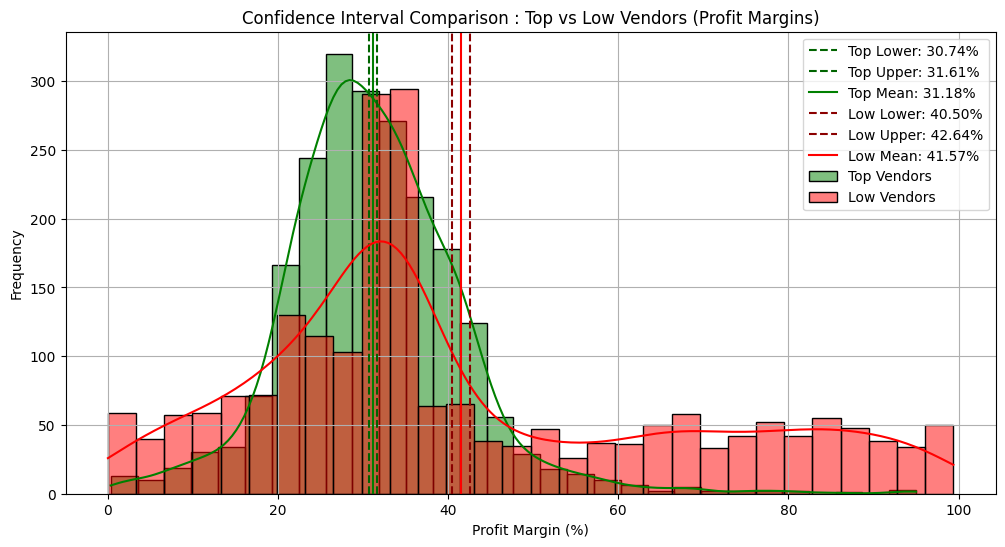

In [67]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors Profit Margin: Mean={top_mean:.2f}%, 95% CI=({top_lower:.2f}%, {top_upper:.2f}%)")
print(f"Low Vendors Profit Margin: Mean={low_mean:.2f}%, 95% CI=({low_lower:.2f}%, {low_upper:.2f}%)")

plt.figure(figsize=(12,6))

# Top Vendors Plot
sns.histplot(top_vendors, color='green', kde=True, alpha=0.5, bins=30, label='Top Vendors')
plt.axvline(top_lower, color='darkgreen', linestyle='--', label=f'Top Lower: {top_lower:.2f}%')
plt.axvline(top_upper, color='darkgreen', linestyle='--', label=f'Top Upper: {top_upper:.2f}%')
plt.axvline(top_mean, color='green', linestyle='-', label=f'Top Mean: {top_mean:.2f}%')

# Low Vendors Plot
sns.histplot(low_vendors, color='red', kde=True, alpha=0.5, bins=30, label='Low Vendors')
plt.axvline(low_lower, color='darkred', linestyle='--', label=f'Low Lower: {low_lower:.2f}%')
plt.axvline(low_upper, color='darkred', linestyle='--', label=f'Low Upper: {low_upper:.2f}%')
plt.axvline(low_mean, color='red', linestyle='-', label=f'Low Mean: {low_mean:.2f}%')

# Finalize Plot
plt.title('Confidence Interval Comparison : Top vs Low Vendors (Profit Margins)')
plt.legend()
plt.xlabel('Profit Margin (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## **Insights:**

- The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%)

- This suggests that vendors with lower sales tends to maintain higher profit margins, potentially due to premium pricing or lower operational costs

- **For High-Performing Vendors:** If they aim to improve profitability, they could explore selective price adjustments, cost optimizing, or bundling strategies

- **For Low-Performing Vendors:** Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies

#### **9. Is there a significant difference in profit margins between top-performing and low-performing vendors?**

**Hypothesis:**

- **H₀ (Null Hypothesis):** There is no significant differencee in the mean profit margins of top-performing and low-performing vendors

- **H₁ (Alternative Hypothesis):** The mean profit margins of top-performing and low-performing vendors are significantly different

In [68]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

top_vendors = df[df['TotalSalesDollars'] >= top_threshold]['ProfitMargin'].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]['ProfitMargin'].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print Results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to reject the null hypothesis: No significant difference in profit margins between top and low-performing vendors.")

T-Statistic: -17.6695, P-Value: 0.0000
Reject the null hypothesis: Significant difference in profit margins between top and low-performing vendors.


## **Result:** 
The null hypothesis is rejected, confirming that the two groups operate under distinctly different profitability models

## **Implication:** 
High-margin vendors may benefit from better pricing strategies, while top-selling vendors could focus on cost efficiency